## Общие преобразования

Класс для общих случаев

In [3]:
class InsDataFrame:


    ''' Load data method '''

    def load_pd(self, pd_dataframe):
        self._df = pd_dataframe


    ''' Columns match method '''

    def columns_match(self, match_from_to):
        self._df.rename(columns=match_from_to, inplace=True)


    ''' Person data methods '''

    # Gender
    _gender_dict = {'Male':0, 'Female':1}

    def transform_gender(self):
        self._df['Gender'] = self._df['Gender'].map(self._gender_dict)

        

    # Age
    @staticmethod
    def _age(age, age_max):
        if pd.isnull(age):
            age = None
        elif age < 18:
            age = None
        elif age > age_max:
            age = age_max
        return age
      
    def transform_age(self, age_max=70):
        self._df['driver_minage'] = self._df['driver_minage'].apply(self._age, args=(age_max,))

    # Age M/F
    @staticmethod
    def _age_gender(age_gender):
        _age = age_gender[0]
        _gender = age_gender[1]
        if _gender == 0: #Male
            _driver_minage_m = _age
            _driver_minage_f = 18
        elif _gender == 1: #Female
            _driver_minage_m = 18
            _driver_minage_f = _age
        else:
            _driver_minage_m = 18
            _driver_minage_f = 18
        return [_driver_minage_m, _driver_minage_f]
    
    def transform_age_gender(self):
        self._df['driver_minage_m'],self._df['driver_minage_f'] = zip(*self._df[['driver_minage','Gender']].apply(self._age_gender, axis=1).to_frame()[0])

    # Experience
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        elif exp > exp_max:
            exp = exp_max
        return exp

    def transform_exp(self, exp_max=52):
        self._df['driver_minexp'] = self._df['driver_minexp'].apply(self._exp, args=(exp_max,))


    ''' Other data methods '''

    def polynomizer(self, column, n=2):
        if column in list(self._df.columns):
            for i in range(2,n+1):
                self._df[column+'_'+str(i)] = self._df[column]**i

    def get_dummies(self, columns):
        self._df = pd.get_dummies(self._df, columns=columns)


    ''' General methods '''

    def info(self):
        return self._df.info()

    def head(self, columns, n=5):
        return self._df.head(n)

    def len(self):
        return len(self._df)

    def get_pd(self, columns):
        return self._df[columns]

Создаем класс-наследник, в котором переопределяем некоторые методы, специфические для конкретной ситуации, и создаем новые

- В данных стаж "LicAge" измеряется в неделях.
- Фактор "SocioCateg" содержит информацию о социальной категории в виде кодов классификации CSP. Агрегируем имеющиеся коды до 1 знака, а затем закодируем их с помощью one-hot encoding.

[Wiki](https://fr.wikipedia.org/wiki/Professions_et_cat%C3%A9gories_socioprofessionnelles_en_France#Cr%C3%A9ation_de_la_nomenclature_des_PCS)

[Более подробный классификатор](https://www.ast74.fr/upload/administratif/liste-des-codes-csp-copie.pdf)

In [4]:
class InsDataFrame_Fr(InsDataFrame):

    # Experience (weeks to years)
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        else:
            exp * 7 // 365
        if exp > exp_max:
            exp = exp_max
        return exp

    # Marital status
    _MariStat_dict = {'Other':0, 'Alone':1}

    def transform_MariStat(self):
        self._df['MariStat'] = self._df['MariStat'].map(self._MariStat_dict)
    
    # Social category
    def transform_SocioCateg(self):
        self._df['SocioCateg'] = self._df['SocioCateg'].str.slice(0,4)

### * Домашнее задание: Многоклассовая классификация

В текущем домашнем задание предлагается взглянуть на задачу моделирования количества страховых случаев как на задачу многоклассовой классификации.

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval, fmin, Trials, STATUS_OK
from functools import partial

from insolver import InsDataFrame, InsolverGradientBoostingWrapper, train_val_test_split

In [6]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [7]:
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

Предобработайте данные

In [8]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

df.loc[df.ClaimsCount > 0, 'AvgClaim'] = df['ClaimAmount']/df['ClaimsCount']

data = InsDataFrame_Fr()
data.load_pd(df)
# Переименовываем
data.columns_match({'DrivAge':'driver_minage','LicAge':'driver_minexp'})
# Преобразовываем
data.transform_age()
data.transform_exp()
data.transform_gender()
data.transform_MariStat()
data.transform_SocioCateg()
# Пересечение пола и возраста, их квадраты
data.transform_age_gender()
data.polynomizer('driver_minage_m')
data.polynomizer('driver_minage_f')
# Onehot encoding
data.get_dummies(['VehUsage','SocioCateg'])

col_features = [
                'driver_minexp',
                'Gender',
                'MariStat',
                'HasKmLimit',
                'BonusMalus',
                'OutUseNb',
                'RiskArea',
                'driver_minage_m',
                'driver_minage_f',
                'driver_minage_m_2',
                'driver_minage_f_2',
                'VehUsage_Private',
                'VehUsage_Private+trip to office',
                'VehUsage_Professional',
                'VehUsage_Professional run',
                'SocioCateg_CSP1',
                'SocioCateg_CSP2',
                'SocioCateg_CSP3',
                'SocioCateg_CSP4',
                'SocioCateg_CSP5',
                'SocioCateg_CSP6',
                'SocioCateg_CSP7'  
]

col_target = ['ClaimAmount', 'ClaimsCount', 'AvgClaim']

df = data.get_pd(col_features+col_target)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   driver_minexp                    115155 non-null  int64  
 1   Gender                           115155 non-null  int64  
 2   MariStat                         115155 non-null  int64  
 3   HasKmLimit                       115155 non-null  int64  
 4   BonusMalus                       115155 non-null  int64  
 5   OutUseNb                         115155 non-null  float64
 6   RiskArea                         115155 non-null  float64
 7   driver_minage_m                  115155 non-null  int64  
 8   driver_minage_f                  115155 non-null  int64  
 9   driver_minage_m_2                115155 non-null  int64  
 10  driver_minage_f_2                115155 non-null  int64  
 11  VehUsage_Private                 115155 non-null  uint8  
 12  Ve

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Заменим значение 11 на 10.

In [10]:
df.loc[df['ClaimsCount'] == 11, 'ClaimsCount'] = 10

C:\Users\infantium\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Посмотрим, сколько полисов соответствуют каждому из значений `ClaimsCount`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [11]:
FreqCount = pd.DataFrame(df.groupby('ClaimsCount').size(), columns=['Count'])
FreqCount['Freq'] = (FreqCount['Count'] - FreqCount['Count'].min()) / (FreqCount['Count'].max() - FreqCount['Count'].min())
FreqCount.head()

,Count,Freq
ClaimsCount,,
0.0,104286,1.000000
1.0,3339,0.032008
2.0,3529,0.033830
3.0,2310,0.022141
4.0,1101,0.010548


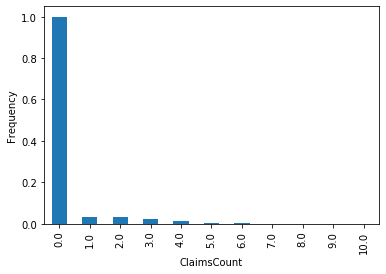

In [12]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [13]:
FreqCount

,Count,Freq
ClaimsCount,,
0.0,104286,1.000000
1.0,3339,0.032008
2.0,3529,0.033830
3.0,2310,0.022141
4.0,1101,0.010548
5.0,428,0.004095
6.0,127,0.001208
7.0,26,0.000240
8.0,6,0.000048


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.05` для значений `ClaimsCount` 0, а для остальных - 1 (Для этого можем использовать функцию `np.where`). Также можно попробовать какой-либо другой способ задания весов, приведенный пример не гарантирует хороших результатов.

In [14]:
df['weight'] = 0
df.loc[df['ClaimAmount'] != 0, 'weight'] = 1
df.loc[df['ClaimAmount'] == 0, 'weight'] = 0.05
df['weight'].value_counts()

C:\Users\infantium\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\infantium\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0.05    104286
1.00     10869
Name: weight, dtype: int64

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [15]:
x_train, x_valid, x_test, \
y_train, y_valid, y_test = train_val_test_split(df.drop(['ClaimAmount', 'ClaimsCount'], axis=1),
                                               df.ClaimsCount, val_size=0.15, test_size=0.15, random_state=10)

Для оптимизации гиперпараметров можно воспользоваться различными методами.

In [17]:
igb = InsolverGradientBoostingWrapper(algorithm='xgboost')

In [18]:
# Определим границы, в которых будем искать гиперпараметры
space_xgboost = {'objective': 'multi:softmax',
              'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
              'min_child_weight': hp.uniform('min_child_weight', 0, 50),
              'subsample': hp.uniform('subsample', 0.5, 1),
              'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
              'alpha': hp.uniform('alpha', 0, 1),
              'lambda': hp.uniform('lambda', 0, 1),
              'eta': hp.uniform('eta', 0.01, 1),
              'gamma': hp.uniform('gamma', 0.01, 1000),
              'num_class': len(df.ClaimsCount.unique()),
              'tree_method': 'hist'
              }

In [19]:
# Определим параметры выполнения кроссвалидации
cv_params = {'num_boost_round': 1000,
             'nfold': 3,
             'early_stopping_rounds': 20,
             'seed': 0,
             'shuffle': True,
             'stratified': False,             
              }

In [20]:
# Оптимизация (количество итераций снижено для ускорения работы)
igb.hyperopt_cv(x_train.drop('weight', axis=1), y_train, space_xgboost, cv_params, 
                data_params={'weight': x_train['weight']}, max_evals=50)

100%|██████████████████| 50/50 [04:32<00:00,  5.44s/trial, best loss: 0.367146]


Далее обучим нашу модель с оптимальными параметрами

In [21]:
igb.fit_booster(x_train.drop('weight', axis=1), y_train, 
                core_params={'evals': [((x_train.drop('weight', axis=1), y_train), 'train'),
                                      ((x_valid.drop('weight', axis=1), y_valid), 'valid')]})

[0]	train-merror:0.05049	valid-merror:0.04938
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 20 rounds.
[1]	train-merror:0.04940	valid-merror:0.04938
[2]	train-merror:0.04878	valid-merror:0.04984
[3]	train-merror:0.04781	valid-merror:0.04973
[4]	train-merror:0.04761	valid-merror:0.04950
[5]	train-merror:0.04682	valid-merror:0.04880
[6]	train-merror:0.04667	valid-merror:0.04932
[7]	train-merror:0.04606	valid-merror:0.04897
[8]	train-merror:0.04569	valid-merror:0.04909
[9]	train-merror:0.04521	valid-merror:0.04921
[10]	train-merror:0.04477	valid-merror:0.04921
[11]	train-merror:0.04435	valid-merror:0.04932
[12]	train-merror:0.04378	valid-merror:0.04834
[13]	train-merror:0.04356	valid-merror:0.04816
[14]	train-merror:0.04325	valid-merror:0.04874
[15]	train-merror:0.04285	valid-merror:0.04892
[16]	train-merror:0.04240	valid-merror:0.04897
[17]	train-merror:0.04186	valid-merror:0.04955
[18]	train-merr

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [26]:
dfsets = [{'set': 'train', 'dmat': x_train.drop('weight', axis=1), 'target': y_train},
          {'set': 'valid', 'dmat': x_valid.drop('weight', axis=1), 'target': y_valid},
          {'set': 'test', 'dmat': x_test.drop('weight', axis=1), 'target': y_test}]
for dfset in dfsets:
    class_preds = igb.booster.predict(xgb.DMatrix(dfset['dmat'])) # Посчитаем предсказанные значения
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds,  average='micro')) # Посчитаем F1 Score

F1 Score on train: 0.9622985596784398
F1 Score on valid: 0.9507930994558296
F1 Score on test: 0.9474933425958088


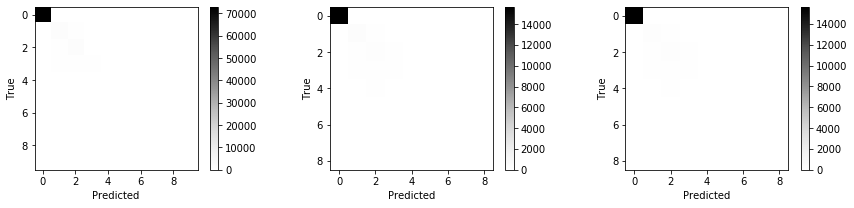

In [30]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], igb.booster.predict(xgb.DMatrix(dfsets[i]['dmat'])))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

Мы получили высокие метрики из-за дисбаланса классов. Для улучшения результата следует воспользоваться методом регрессии